In [52]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [53]:
from keras.models import Model
from keras.layers import Conv2D, Input, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Input, ReLU,BatchNormalization,LeakyReLU,Identity
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam


from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


In [54]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [55]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [56]:
df['txt_content'].str.len().value_counts()

txt_content
6    7997
7       3
Name: count, dtype: int64

In [57]:
from PIL import Image, ImageDraw, ImageFont

font_path = '../dados/targa/Targa.ttf'

In [58]:
def generate_clean_captcha(text):
    # Fixed parameters
    size = (180, 50)  # Change size to (height, width)
    font_size = 24
    num_parts = 7

    # Create a blank white image
    image = Image.new('L', size, 255)  # 'L' mode for grayscale

    # Load the custom font
    font = ImageFont.truetype(font_path, font_size)

    # Create a drawing context
    draw = ImageDraw.Draw(image)

    # Calculate positions for each part
    part_width = size[0] / num_parts
    horizontal_positions = [int(part_width * i + part_width / 2) for i in range(num_parts)]
    horizontal_positions = horizontal_positions[:len(text)]  # Adjust to the length of the text

    # Calculate y position to center the text vertically
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_height = text_bbox[3] - text_bbox[1]
    text_y = (size[1] - text_height) // 2

    # Draw each letter at the calculated position
    for char, x in zip(text, horizontal_positions):
        char_bbox = draw.textbbox((0, 0), char, font=font)
        char_width = char_bbox[2] - char_bbox[0]
        char_x = x - char_width // 2  # Center the character horizontally within its part
        draw.text((char_x, text_y), char, font=font, fill=0)

    # Convert to numpy array if needed for further processing with OpenCV
    captcha_image = np.array(image)

    return captcha_image

In [59]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [60]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  df['txt_content'] = df['txt_content'].apply(lambda x: x + "]" if len(x) == 6 else x)
  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  Y = np.array([generate_clean_captcha(x) for x in df["txt_content"]])
  X = X.astype('float32') / 255.
  Y = Y.astype('float32') / 255.
  return X,Y

X_train, Y_train = generate_X_Y('../dados/CAPTCHA-10k/treinamento')
X_val, Y_val = generate_X_Y('../dados/CAPTCHA-10k/validacao')

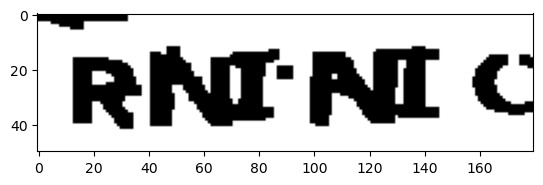

In [61]:
plt.imshow(X_train[0], cmap='gray')

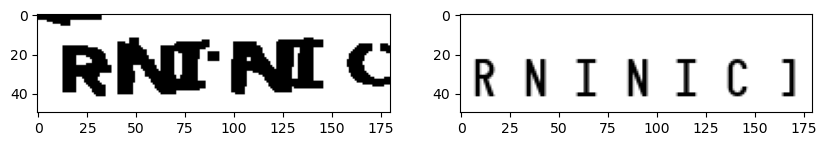

In [62]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')

# Display the corresponding Y_train[0]
plt.subplot(1, 2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.show()

In [63]:
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)
batch_size = 64
augmented_data_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)

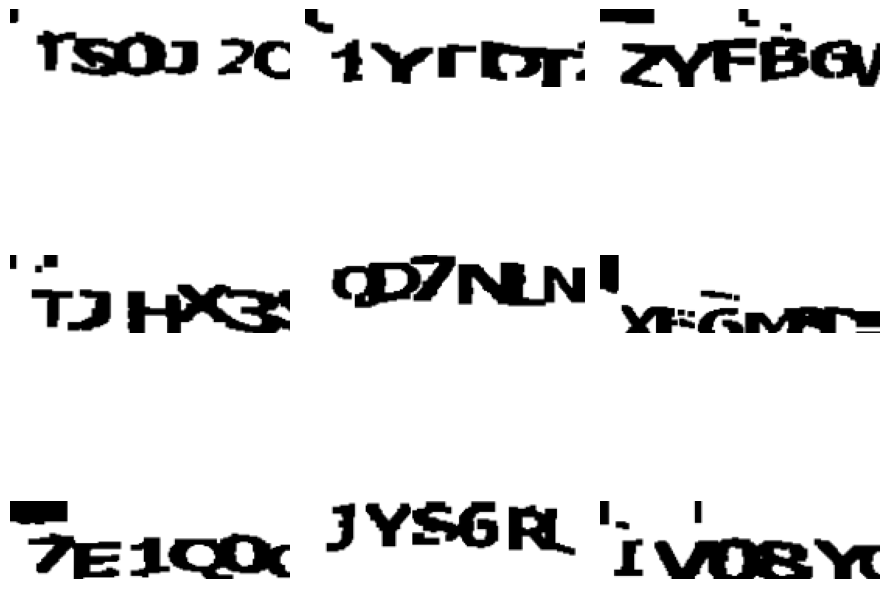

In [64]:
augmented_images, augmented_labels = next(augmented_data_generator)

# Display the first few augmented images and their corresponding labels
plt.figure(figsize=(9, 9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].reshape(50, 180), cmap='gray')  # Assuming images are grayscale
    plt.axis('off')
plt.tight_layout()
plt.show()

In [65]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [66]:
#Camada Convolution-BatchNorm-ReLu
def CK(filters, kernel_size=(4, 4), strides=(2, 2), padding='same', use_batch_norm=True, downsample=True):
    '''
        filters: quantidade de filtros
        kernel_size 3x3 | strides 1x1 | padding same | sao constantes durante o codigo
        use_batch_norm ->   indica quando devemos usar BatchNormalization, em caso de negativo, a camada se torna a Identidade
        downsample ->       indica se a dimensao deve aumentar ou diminuir 
    '''

    # Esse chavemento usando  if ternario serve para selecionar as camadas com base nos atributos
    conv = Conv2D               if downsample       else Conv2DTranspose
    norm = BatchNormalization   if use_batch_norm   else Identity
    actf = LeakyReLU(0.2)       if downsample       else ReLU()
    # alpha de 0.2 na LeakyReLU foi definido no paper original

    # Com o chaveamento pronto, a camada pode ser montada sequencialmente
    def layer(x):
        x = conv(filters, kernel_size, strides=strides, padding=padding)(x)
        x = norm()(x)
        x = actf(x)
        return x
    return layer

In [67]:
def crop_and_concat(x1, x2):
    # Crop x2 to the shape of x1
    x1_shape = x1.shape
    x2_shape = x2.shape
    height_diff = x2_shape[1] - x1_shape[1]
    width_diff = x2_shape[2] - x1_shape[2]

    cropping = ((height_diff // 2, height_diff - height_diff // 2),
                (width_diff // 2, width_diff - width_diff // 2))
    x2_cropped = Cropping2D(cropping)(x2)
    return concatenate([x1, x2_cropped])

In [68]:
def generator(input_nc, output_nc, ngf, num_blocks=1, num_downsample=3):
    # Aqui, definimos o modelo gerador
    
    # Ele deve receber uma imagem (img_size,img_size,input_nc)
    inputs = Input(shape=(50, 180, input_nc))

    # --------------- START ENCODER --------------------------

    x = inputs

    # Uma convolucao eh aplicada inicialmente sem o batch_norm
    x = CK(ngf,use_batch_norm=False)(x)
    # img_shape = img_size/2,img_size/2,ngf

    # Aqui implementamos o caminho onde a dimensao da imagem vai diminuindo
    #Armazenamos as skip connections
    skips = []
    for i in range(num_downsample + num_blocks - 1):
        # Como o numero de filtros vai aumentando exponencialmente, existe um momento em que o crescimento eh cessado e a qtd se torna constante
        # Este e o momento em que i+1 >= num_downsample
        # A partir dai, o numero de filtros nao diminui
        expo = min(i+1,num_downsample)
        # Aplicamos convolucao com o numero de filtros escolhido
        x = CK(ngf*(2**(expo)))(x)
        # Guardamos a coneccao
        skips.append(x)
    shape_before_flattening = x.shape[1:]
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    # --------------- FIM   ENCODER --------------------------
    '''
    Aqui, a imagem esta no formato:
    img_shape = img_size/(num_downsample + num_blocks),img_size/(num_downsample + num_blocks),ngf*(2**(expo))
    
    '''
    # --------------- START DECODER --------------------------

    # As conexoes sao processadas de tras pra frente, ja que a ultima skip gerada vai se ligar com a primeira camada do decoder
    skips = list(reversed(skips))

    x = Dense(np.prod(shape_before_flattening), activation='relu')(x)
    x = Reshape(shape_before_flattening)(x)
    # Para as skips que sobraram, devemos conecta-las a camadas sem dropout
    for skip in skips:
        # x = Concatenate()([x, skip])
        x = crop_and_concat(skip,x)
        x = CK(ngf * (2 ** i),downsample=False)(x)
    
    #    img_shape = img_size/(2),img_size/(2),ngf*(2**(expo))
    # --------------- FIM   DECODER --------------------------

    # Por fim, uma ultima convolucao com TanH para gerar o resultado final
    # Numero de canais = output_nc  = 3 = RGB
    x = Conv2DTranspose(ngf, (4, 4),strides=(2,2), activation='relu',padding="same")(x)
    x = Conv2D(ngf, (3, 1),strides=(1,1), activation='relu')(x)
    output = Conv2D(output_nc, (1, 1),strides=(1,1), activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=output)

autoencoder = generator(1, 1, 16, num_blocks=3, num_downsample=4)
autoencoder.compile(optimizer=Adam(2e-4, beta_1=0.5,beta_2=0.999), loss=binary_crossentropy,metrics=[rmse,psnr])
autoencoder.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 50, 180, 1)]         0         []                            
                                                                                                  
 conv2d_148 (Conv2D)         (None, 25, 90, 16)           272       ['input_16[0][0]']            
                                                                                                  
 identity_15 (Identity)      (None, 25, 90, 16)           0         ['conv2d_148[0][0]']          
                                                                                                  
 leaky_re_lu_120 (LeakyReLU  (None, 25, 90, 16)           0         ['identity_15[0][0]']         
 )                                                                                         

In [69]:
checkpoint = ModelCheckpoint(
    'model_BCE_aug_best_unet.tf',
    monitor='val_rmse',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [70]:
history = autoencoder.fit(augmented_data_generator,
                steps_per_epoch=len(X_train) // batch_size,
                epochs=300,
                batch_size=batch_size,
                shuffle=True,
                callbacks=[checkpoint],
                validation_data=(X_val, Y_val))

Epoch 1/300
125/125 [==============================] - ETA: 0s - loss: 0.1050 - rmse: 0.3165 - psnr: 10.1197
Epoch 1: val_rmse improved from inf to 0.59002, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 36s 218ms/step - loss: 0.1050 - rmse: 0.3165 - psnr: 10.1197 - val_loss: 0.3481 - val_rmse: 0.5900 - val_psnr: 4.5827
Epoch 2/300
125/125 [==============================] - ETA: 0s - loss: 0.0742 - rmse: 0.2722 - psnr: 11.3085
Epoch 2: val_rmse improved from 0.59002 to 0.31931, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 32s 253ms/step - loss: 0.0742 - rmse: 0.2722 - psnr: 11.3085 - val_loss: 0.1020 - val_rmse: 0.3193 - val_psnr: 9.9159
Epoch 3/300
125/125 [==============================] - ETA: 0s - loss: 0.0611 - rmse: 0.2470 - psnr: 12.1539
Epoch 3: val_rmse improved from 0.31931 to 0.25088, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 29s 230ms/step - loss: 0.0611 - rmse: 0.2470 - psnr: 12.1539 - val_loss: 0.0630 - val_rmse: 0.2509 - val_psnr: 12.0129
Epoch 4/300
125/125 [==============================] - ETA: 0s - loss: 0.0512 - rmse: 0.2261 - psnr: 12.9209
Epoch 4: val_rmse improved from 0.25088 to 0.20824, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 243ms/step - loss: 0.0512 - rmse: 0.2261 - psnr: 12.9209 - val_loss: 0.0434 - val_rmse: 0.2082 - val_psnr: 13.6335
Epoch 5/300
125/125 [==============================] - ETA: 0s - loss: 0.0448 - rmse: 0.2115 - psnr: 13.5035
Epoch 5: val_rmse improved from 0.20824 to 0.18842, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 27s 219ms/step - loss: 0.0448 - rmse: 0.2115 - psnr: 13.5035 - val_loss: 0.0355 - val_rmse: 0.1884 - val_psnr: 14.5078
Epoch 6/300
125/125 [==============================] - ETA: 0s - loss: 0.0401 - rmse: 0.1999 - psnr: 13.9906
Epoch 6: val_rmse improved from 0.18842 to 0.18686, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 28s 227ms/step - loss: 0.0401 - rmse: 0.1999 - psnr: 13.9906 - val_loss: 0.0349 - val_rmse: 0.1869 - val_psnr: 14.5790
Epoch 7/300
125/125 [==============================] - ETA: 0s - loss: 0.0350 - rmse: 0.1870 - psnr: 14.5762
Epoch 7: val_rmse improved from 0.18686 to 0.16272, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 241ms/step - loss: 0.0350 - rmse: 0.1870 - psnr: 14.5762 - val_loss: 0.0265 - val_rmse: 0.1627 - val_psnr: 15.7819
Epoch 8/300
125/125 [==============================] - ETA: 0s - loss: 0.0319 - rmse: 0.1783 - psnr: 14.9920
Epoch 8: val_rmse improved from 0.16272 to 0.15771, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 242ms/step - loss: 0.0319 - rmse: 0.1783 - psnr: 14.9920 - val_loss: 0.0248 - val_rmse: 0.1577 - val_psnr: 16.0567
Epoch 9/300
125/125 [==============================] - ETA: 0s - loss: 0.0293 - rmse: 0.1709 - psnr: 15.3588
Epoch 9: val_rmse improved from 0.15771 to 0.14880, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 26s 209ms/step - loss: 0.0293 - rmse: 0.1709 - psnr: 15.3588 - val_loss: 0.0221 - val_rmse: 0.1488 - val_psnr: 16.5620
Epoch 10/300
125/125 [==============================] - ETA: 0s - loss: 0.0273 - rmse: 0.1649 - psnr: 15.6710
Epoch 10: val_rmse improved from 0.14880 to 0.13456, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 31s 245ms/step - loss: 0.0273 - rmse: 0.1649 - psnr: 15.6710 - val_loss: 0.0181 - val_rmse: 0.1346 - val_psnr: 17.4369
Epoch 11/300
125/125 [==============================] - ETA: 0s - loss: 0.0250 - rmse: 0.1580 - psnr: 16.0447
Epoch 11: val_rmse did not improve from 0.13456
125/125 [==============================] - 19s 153ms/step - loss: 0.0250 - rmse: 0.1580 - psnr: 16.0447 - val_loss: 0.0194 - val_rmse: 0.1394 - val_psnr: 17.1305
Epoch 12/300
125/125 [==============================] - ETA: 0s - loss: 0.0239 - rmse: 0.1543 - psnr: 16.2526
Epoch 12: val_rmse improved from 0.13456 to 0.12662, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 39s 316ms/step - loss: 0.0239 - rmse: 0.1543 - psnr: 16.2526 - val_loss: 0.0161 - val_rmse: 0.1266 - val_psnr: 17.9813
Epoch 13/300
125/125 [==============================] - ETA: 0s - loss: 0.0230 - rmse: 0.1514 - psnr: 16.4200
Epoch 13: val_rmse did not improve from 0.12662
125/125 [==============================] - 19s 153ms/step - loss: 0.0230 - rmse: 0.1514 - psnr: 16.4200 - val_loss: 0.0210 - val_rmse: 0.1448 - val_psnr: 16.7981
Epoch 14/300
125/125 [==============================] - ETA: 0s - loss: 0.0214 - rmse: 0.1459 - psnr: 16.7382
Epoch 14: val_rmse did not improve from 0.12662
125/125 [==============================] - 19s 153ms/step - loss: 0.0214 - rmse: 0.1459 - psnr: 16.7382 - val_loss: 0.0161 - val_rmse: 0.1267 - val_psnr: 17.9741
Epoch 15/300
125/125 [==============================] - ETA: 0s - loss: 0.0203 - rmse: 0.1421 - psnr: 16.9737
Epoch 15: val_rmse improved from 0.12662 to 0.11755, saving model to model_MSE_aug_best_

INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 36s 288ms/step - loss: 0.0203 - rmse: 0.1421 - psnr: 16.9737 - val_loss: 0.0138 - val_rmse: 0.1175 - val_psnr: 18.6276
Epoch 16/300
125/125 [==============================] - ETA: 0s - loss: 0.0202 - rmse: 0.1418 - psnr: 16.9910
Epoch 16: val_rmse did not improve from 0.11755
125/125 [==============================] - 20s 158ms/step - loss: 0.0202 - rmse: 0.1418 - psnr: 16.9910 - val_loss: 0.0138 - val_rmse: 0.1176 - val_psnr: 18.6231
Epoch 17/300
125/125 [==============================] - ETA: 0s - loss: 0.0194 - rmse: 0.1387 - psnr: 17.1828
Epoch 17: val_rmse did not improve from 0.11755
125/125 [==============================] - 20s 158ms/step - loss: 0.0194 - rmse: 0.1387 - psnr: 17.1828 - val_loss: 0.0144 - val_rmse: 0.1200 - val_psnr: 18.4511
Epoch 18/300
125/125 [==============================] - ETA: 0s - loss: 0.0186 - rmse: 0.1359 - psnr: 17.3609
Epoch 18: val_rmse improved from 0.11755 to 0.11375, saving model to model_MSE_aug_best_

INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 39s 315ms/step - loss: 0.0186 - rmse: 0.1359 - psnr: 17.3609 - val_loss: 0.0130 - val_rmse: 0.1137 - val_psnr: 18.9137
Epoch 19/300
125/125 [==============================] - ETA: 0s - loss: 0.0187 - rmse: 0.1363 - psnr: 17.3388
Epoch 19: val_rmse improved from 0.11375 to 0.10655, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 29s 233ms/step - loss: 0.0187 - rmse: 0.1363 - psnr: 17.3388 - val_loss: 0.0114 - val_rmse: 0.1066 - val_psnr: 19.5129
Epoch 20/300
125/125 [==============================] - ETA: 0s - loss: 0.0174 - rmse: 0.1315 - psnr: 17.6443
Epoch 20: val_rmse did not improve from 0.10655
125/125 [==============================] - 20s 156ms/step - loss: 0.0174 - rmse: 0.1315 - psnr: 17.6443 - val_loss: 0.0154 - val_rmse: 0.1243 - val_psnr: 18.1229
Epoch 21/300
125/125 [==============================] - ETA: 0s - loss: 0.0171 - rmse: 0.1306 - psnr: 17.7029
Epoch 21: val_rmse did not improve from 0.10655
125/125 [==============================] - 20s 156ms/step - loss: 0.0171 - rmse: 0.1306 - psnr: 17.7029 - val_loss: 0.0123 - val_rmse: 0.1109 - val_psnr: 19.1354
Epoch 22/300
125/125 [==============================] - ETA: 0s - loss: 0.0166 - rmse: 0.1282 - psnr: 17.8786
Epoch 22: val_rmse did not improve from 0.10655
125/125 [==============================]

INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 33s 264ms/step - loss: 0.0164 - rmse: 0.1277 - psnr: 17.9041 - val_loss: 0.0103 - val_rmse: 0.1016 - val_psnr: 19.8928
Epoch 24/300
125/125 [==============================] - ETA: 0s - loss: 0.0159 - rmse: 0.1257 - psnr: 18.0488
Epoch 24: val_rmse did not improve from 0.10157
125/125 [==============================] - 20s 156ms/step - loss: 0.0159 - rmse: 0.1257 - psnr: 18.0488 - val_loss: 0.0107 - val_rmse: 0.1036 - val_psnr: 19.7656
Epoch 25/300
125/125 [==============================] - ETA: 0s - loss: 0.0158 - rmse: 0.1253 - psnr: 18.0765
Epoch 25: val_rmse did not improve from 0.10157
125/125 [==============================] - 20s 156ms/step - loss: 0.0158 - rmse: 0.1253 - psnr: 18.0765 - val_loss: 0.0161 - val_rmse: 0.1270 - val_psnr: 17.9502
Epoch 26/300
125/125 [==============================] - ETA: 0s - loss: 0.0156 - rmse: 0.1241 - psnr: 18.1690
Epoch 26: val_rmse did not improve from 0.10157
125/125 [==============================]

INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 243ms/step - loss: 0.0155 - rmse: 0.1240 - psnr: 18.1641 - val_loss: 0.0097 - val_rmse: 0.0987 - val_psnr: 20.1531
Epoch 28/300
125/125 [==============================] - ETA: 0s - loss: 0.0148 - rmse: 0.1214 - psnr: 18.3438
Epoch 28: val_rmse did not improve from 0.09869
125/125 [==============================] - 20s 158ms/step - loss: 0.0148 - rmse: 0.1214 - psnr: 18.3438 - val_loss: 0.0098 - val_rmse: 0.0990 - val_psnr: 20.1311
Epoch 29/300
125/125 [==============================] - ETA: 0s - loss: 0.0144 - rmse: 0.1196 - psnr: 18.4836
Epoch 29: val_rmse improved from 0.09869 to 0.09597, saving model to model_MSE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 31s 251ms/step - loss: 0.0144 - rmse: 0.1196 - psnr: 18.4836 - val_loss: 0.0092 - val_rmse: 0.0960 - val_psnr: 20.4160
Epoch 30/300
125/125 [==============================] - ETA: 0s - loss: 0.0140 - rmse: 0.1177 - psnr: 18.6201
Epoch 30: val_rmse did not improve from 0.09597
125/125 [==============================] - 20s 156ms/step - loss: 0.0140 - rmse: 0.1177 - psnr: 18.6201 - val_loss: 0.0097 - val_rmse: 0.0980 - val_psnr: 20.2446
Epoch 31/300
125/125 [==============================] - ETA: 0s - loss: 0.0146 - rmse: 0.1203 - psnr: 18.4264
Epoch 31: val_rmse did not improve from 0.09597
125/125 [==============================] - 20s 156ms/step - loss: 0.0146 - rmse: 0.1203 - psnr: 18.4264 - val_loss: 0.0095 - val_rmse: 0.0973 - val_psnr: 20.2826
Epoch 32/300
125/125 [==============================] - ETA: 0s - loss: 0.0143 - rmse: 0.1189 - psnr: 18.5356
Epoch 32: val_rmse improved from 0.09597 to 0.09490, saving model to model_MSE_aug_best_

INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 58s 469ms/step - loss: 0.0143 - rmse: 0.1189 - psnr: 18.5356 - val_loss: 0.0090 - val_rmse: 0.0949 - val_psnr: 20.5252
Epoch 33/300
125/125 [==============================] - ETA: 0s - loss: 0.0137 - rmse: 0.1167 - psnr: 18.6936
Epoch 33: val_rmse did not improve from 0.09490
125/125 [==============================] - 20s 159ms/step - loss: 0.0137 - rmse: 0.1167 - psnr: 18.6936 - val_loss: 0.0139 - val_rmse: 0.1177 - val_psnr: 18.6075
Epoch 34/300
125/125 [==============================] - ETA: 0s - loss: 0.0140 - rmse: 0.1176 - psnr: 18.6365
Epoch 34: val_rmse did not improve from 0.09490
125/125 [==============================] - 20s 158ms/step - loss: 0.0140 - rmse: 0.1176 - psnr: 18.6365 - val_loss: 0.0108 - val_rmse: 0.1039 - val_psnr: 19.7244
Epoch 35/300
125/125 [==============================] - ETA: 0s - loss: 0.0137 - rmse: 0.1163 - psnr: 18.7375
Epoch 35: val_rmse did not improve from 0.09490
125/125 [==============================]

INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 40s 318ms/step - loss: 0.0129 - rmse: 0.1129 - psnr: 18.9954 - val_loss: 0.0080 - val_rmse: 0.0897 - val_psnr: 21.0135
Epoch 39/300
125/125 [==============================] - ETA: 0s - loss: 0.0129 - rmse: 0.1130 - psnr: 18.9908
Epoch 39: val_rmse did not improve from 0.08968
125/125 [==============================] - 20s 156ms/step - loss: 0.0129 - rmse: 0.1130 - psnr: 18.9908 - val_loss: 0.0114 - val_rmse: 0.1066 - val_psnr: 19.4706
Epoch 40/300
125/125 [==============================] - ETA: 0s - loss: 0.0124 - rmse: 0.1109 - psnr: 19.1343
Epoch 40: val_rmse did not improve from 0.08968
125/125 [==============================] - 20s 156ms/step - loss: 0.0124 - rmse: 0.1109 - psnr: 19.1343 - val_loss: 0.0090 - val_rmse: 0.0944 - val_psnr: 20.5731
Epoch 41/300
125/125 [==============================] - ETA: 0s - loss: 0.0124 - rmse: 0.1108 - psnr: 19.1569
Epoch 41: val_rmse improved from 0.08968 to 0.08774, saving model to model_MSE_aug_best_

INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 36s 285ms/step - loss: 0.0124 - rmse: 0.1108 - psnr: 19.1569 - val_loss: 0.0077 - val_rmse: 0.0877 - val_psnr: 21.2181
Epoch 42/300
125/125 [==============================] - ETA: 0s - loss: 0.0120 - rmse: 0.1090 - psnr: 19.2921
Epoch 42: val_rmse did not improve from 0.08774
125/125 [==============================] - 20s 157ms/step - loss: 0.0120 - rmse: 0.1090 - psnr: 19.2921 - val_loss: 0.0127 - val_rmse: 0.1127 - val_psnr: 18.9844
Epoch 43/300
125/125 [==============================] - ETA: 0s - loss: 0.0122 - rmse: 0.1099 - psnr: 19.2289
Epoch 43: val_rmse did not improve from 0.08774
125/125 [==============================] - 20s 159ms/step - loss: 0.0122 - rmse: 0.1099 - psnr: 19.2289 - val_loss: 0.0086 - val_rmse: 0.0925 - val_psnr: 20.7462
Epoch 44/300
125/125 [==============================] - ETA: 0s - loss: 0.0121 - rmse: 0.1091 - psnr: 19.2988
Epoch 44: val_rmse did not improve from 0.08774
125/125 [==============================]

INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 30s 243ms/step - loss: 0.0109 - rmse: 0.1039 - psnr: 19.7174 - val_loss: 0.0077 - val_rmse: 0.0875 - val_psnr: 21.2601
Epoch 56/300
125/125 [==============================] - ETA: 0s - loss: 0.0105 - rmse: 0.1017 - psnr: 19.9237
Epoch 56: val_rmse did not improve from 0.08750
125/125 [==============================] - 20s 156ms/step - loss: 0.0105 - rmse: 0.1017 - psnr: 19.9237 - val_loss: 0.0101 - val_rmse: 0.1005 - val_psnr: 20.0005
Epoch 57/300
125/125 [==============================] - ETA: 0s - loss: 0.0107 - rmse: 0.1027 - psnr: 19.8167
Epoch 57: val_rmse did not improve from 0.08750
125/125 [==============================] - 20s 156ms/step - loss: 0.0107 - rmse: 0.1027 - psnr: 19.8167 - val_loss: 0.0113 - val_rmse: 0.1065 - val_psnr: 19.4999
Epoch 58/300
125/125 [==============================] - ETA: 0s - loss: 0.0106 - rmse: 0.1025 - psnr: 19.8469
Epoch 58: val_rmse did not improve from 0.08750
125/125 [==============================]

INFO:tensorflow:Assets written to: model_MSE_aug_best_unet.tf/assets


125/125 [==============================] - 27s 215ms/step - loss: 0.0097 - rmse: 0.0976 - psnr: 20.2692 - val_loss: 0.0075 - val_rmse: 0.0863 - val_psnr: 21.3835
Epoch 63/300
125/125 [==============================] - ETA: 0s - loss: 0.0099 - rmse: 0.0988 - psnr: 20.1605
Epoch 63: val_rmse did not improve from 0.08625
125/125 [==============================] - 20s 159ms/step - loss: 0.0099 - rmse: 0.0988 - psnr: 20.1605 - val_loss: 0.0091 - val_rmse: 0.0953 - val_psnr: 20.4824
Epoch 64/300
125/125 [==============================] - ETA: 0s - loss: 0.0099 - rmse: 0.0986 - psnr: 20.1964
Epoch 64: val_rmse did not improve from 0.08625
125/125 [==============================] - 20s 159ms/step - loss: 0.0099 - rmse: 0.0986 - psnr: 20.1964 - val_loss: 0.0081 - val_rmse: 0.0902 - val_psnr: 20.9722
Epoch 65/300
125/125 [==============================] - ETA: 0s - loss: 0.0096 - rmse: 0.0971 - psnr: 20.3207
Epoch 65: val_rmse did not improve from 0.08625
125/125 [==============================]

In [71]:
Y_train_pred = autoencoder.predict(X_train)
Y_val_pred = autoencoder.predict(X_val)

32/32 [==============================] - 2s 42ms/step


In [72]:
def display_images(images, Y, Y_pred, num_images=10):
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(20, 6))
    for i, idx in enumerate(indices):
        # Original images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[idx].reshape(50,180), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Ground truth labels (Y)
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(Y[idx].reshape(50, 180), cmap="gray")
        plt.title("Y")
        plt.axis("off")

        # Reconstructed images (Y_pred)
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(Y_pred[idx].reshape(50, 180), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

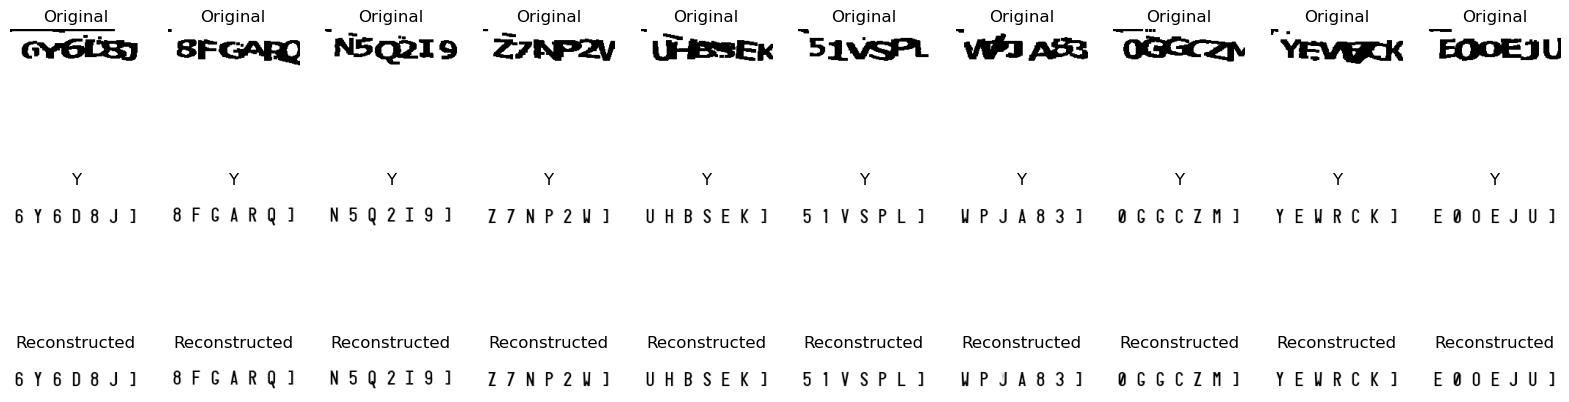

In [73]:
display_images(X_train, Y_train, Y_train_pred, num_images=10)

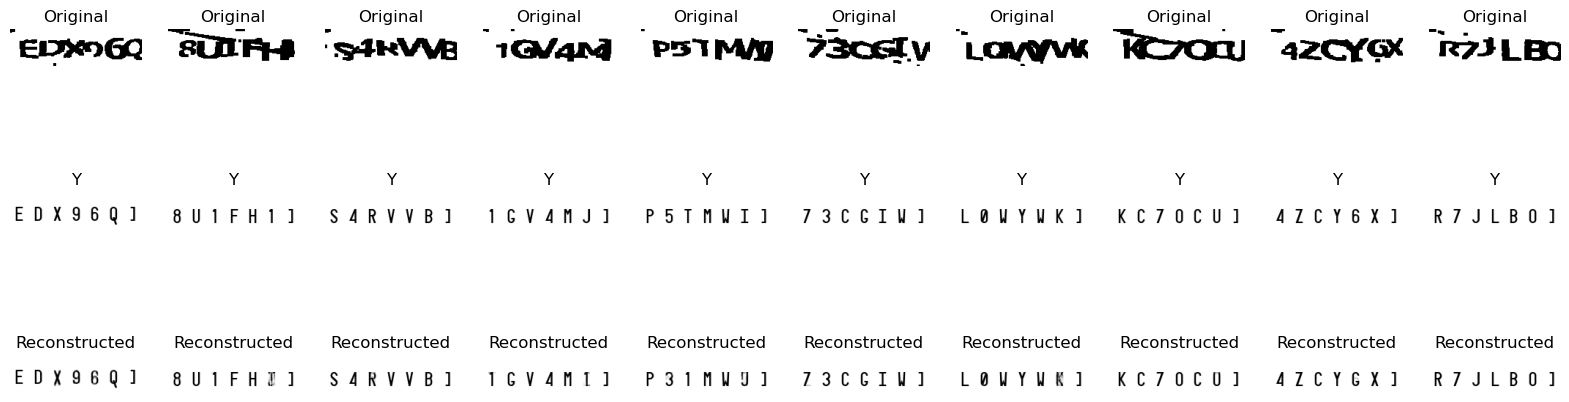

In [75]:
display_images(X_val, Y_val, Y_val_pred, num_images=10)